# 01. Import libraries & data

In [16]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [17]:
# Configure API key 

quandl.ApiConfig.api_key = 'W5DpuepAsCJNef8DvkZL'

In [18]:
# Importing the Federal Reserve Economic Data "Personal Saving Rate" variable.

data = quandl.get('FRED/PSAVERT')

In [19]:
data.head(5)

,Value
Date,
1959-01-01,11.3
1959-02-01,10.6
1959-03-01,10.3
1959-04-01,11.2
1959-05-01,10.6


In [20]:
data.shape

(752, 1)

In [21]:
data.columns

Index(['Value'], dtype='object')

In [22]:
type(data)

pandas.core.frame.DataFrame

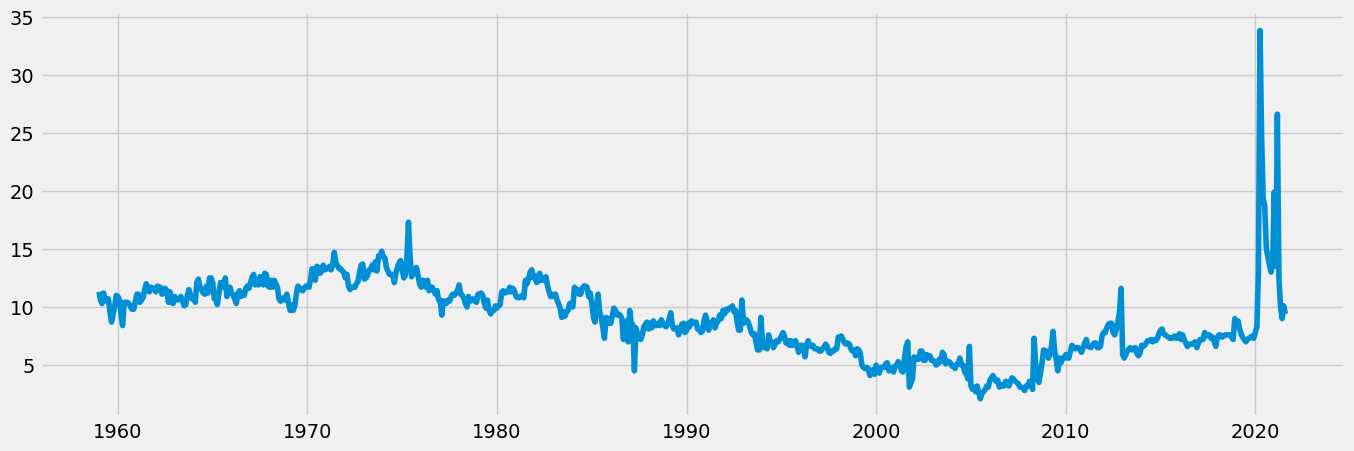

In [23]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 02. Subsetting, wrangling, and cleaning time-series data

In [24]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [25]:
data_2.head()

,Date,Value
0,1959-01-01,11.3
1,1959-02-01,10.6
2,1959-03-01,10.3
3,1959-04-01,11.2
4,1959-05-01,10.6


In [26]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [27]:
data_sub.shape

(485, 2)

In [28]:
data_sub.head()

,Date,Value
252,1980-01-01,9.9
253,1980-02-01,10.1
254,1980-03-01,10.2
255,1980-04-01,11.3
256,1980-05-01,11.4


In [29]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,9.9
1980-02-01,10.1
1980-03-01,10.2
1980-04-01,11.3
1980-05-01,11.4


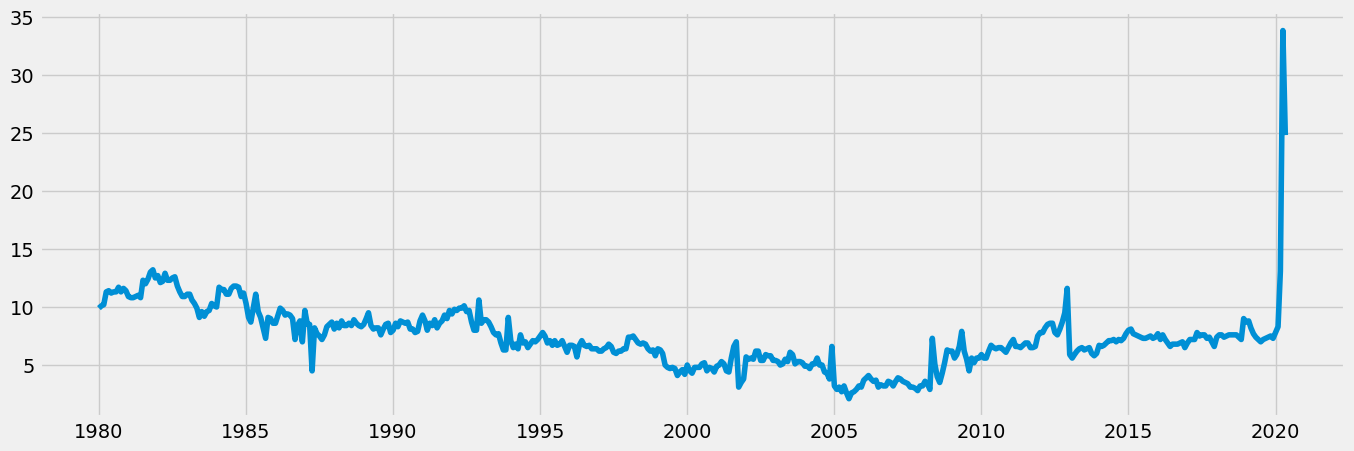

In [30]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [31]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [33]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

380

In [37]:
dups

datetime
1980-01-01    False
1980-02-01    False
1980-03-01    False
1980-04-01    False
1980-05-01    False
              ...  
2020-01-01     True
2020-02-01     True
2020-03-01    False
2020-04-01    False
2020-05-01    False
Length: 485, dtype: bool

In [38]:
# check the current number of rows
data_sub.shape

(485, 1)

In [39]:
# create a new dataframe that doesn’t include the duplicates
data_sub_no_dups = data_sub.drop_duplicates()

In [40]:
data_sub_no_dups.shape

(105, 1)

# 03. Time-series analysis: decomposition

In [42]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [43]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

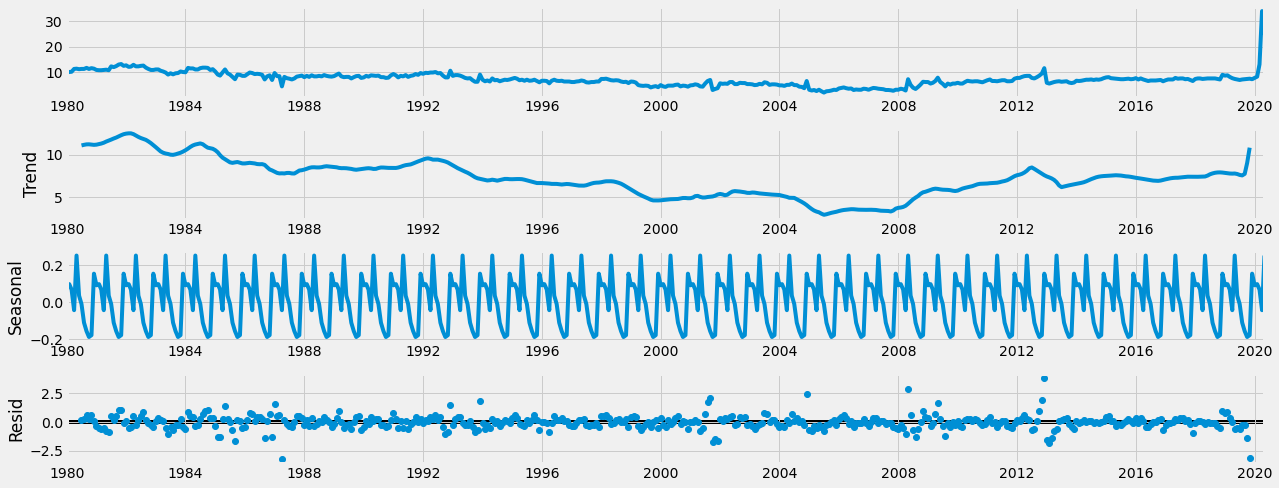

In [58]:
# Plot the separate components

decomposition.plot()
plt.show()

The first chart in the figure above is the data itself (including all of its components). This is called the level.

The trend in the chart above gradually drops in a linear fashion after 1980. The highest dip is around 2005 and 2006. While there’s one jump around 2009 and 2010, likely due to the global financial crisis, the overall trend continues to decrease all the way until the present year. This is called a dominant trend.

The third component is the seasonality. Here, you see seasonal fluctuations represented by a spikey curve that changes at a regular interval. If you didn’t have any seasonality (which is rarely the case), the curve would be flat.

And finally comes the noise. You can see here that there isn’t much unexplained noise apart from the period of time around the 2009 financial crisis, where there are a number of up-and-down deviations.

# 04. Testing for stationarity

In [45]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.910356
p-value                          0.784543
Number of Lags Used              3.000000
Number of Observations Used    481.000000
Critical Value (1%)             -3.444018
Critical Value (5%)             -2.867568
Critical Value (10%)            -2.569980
dtype: float64


The test statistic is -0.910356 and the p-value is 0.784543 which indicates the test result is not significant as a “significant” result would be a p-value of less than 0.05. Using the critical value (5%) which is -2.867568, it is much smaller than the test statistic. This means you cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

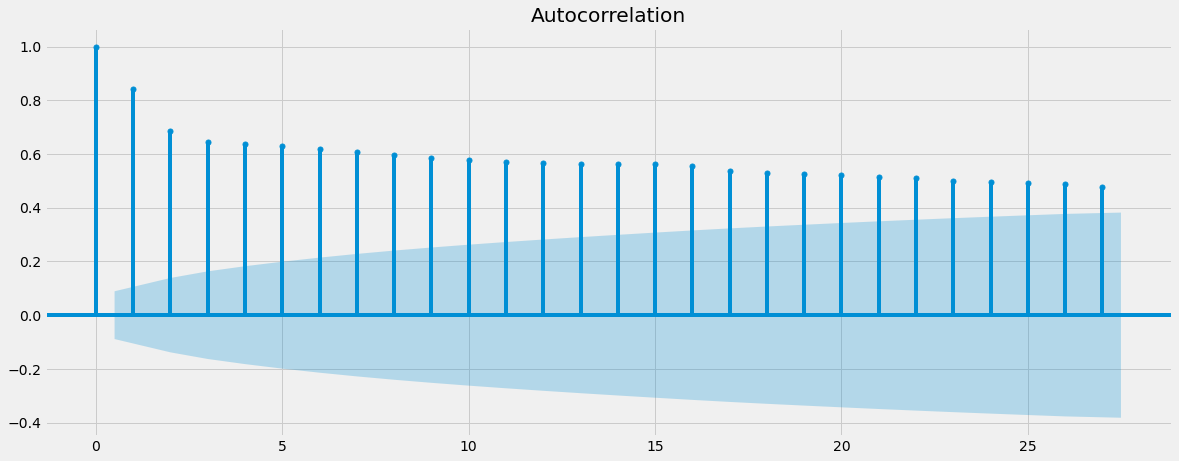

In [46]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

# 05. Stationarizing the Federal Reserve Economic Data

In [47]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [48]:
data_diff.head()

,Value
datetime,
1980-01-01,NaN
1980-02-01,0.2
1980-03-01,0.1
1980-04-01,1.1
1980-05-01,0.1


In [49]:
data_diff.columns

Index(['Value'], dtype='object')

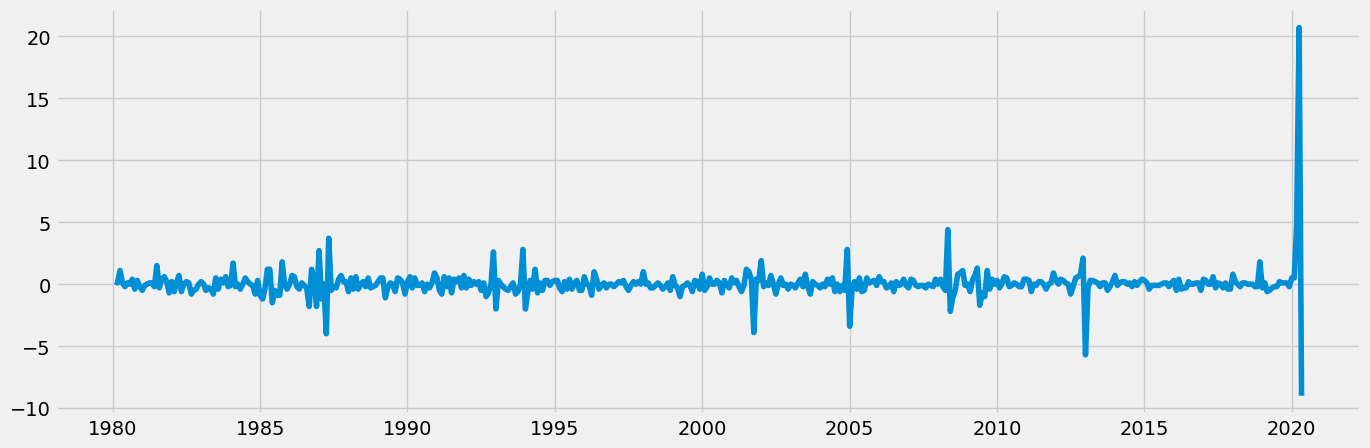

In [50]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [52]:
# finding missing values
data_diff.isnull().sum()

Value    1
dtype: int64

In [53]:
data_diff = data_diff.dropna(axis=0, subset=['Value'])

In [54]:
data_diff.head()

,Value
datetime,
1980-02-01,0.2
1980-03-01,0.1
1980-04-01,1.1
1980-05-01,0.1
1980-06-01,-0.2


In [55]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.239904e+01
p-value                        4.605074e-23
Number of Lags Used            2.000000e+00
Number of Observations Used    4.810000e+02
Critical Value (1%)           -3.444018e+00
Critical Value (5%)           -2.867568e+00
Critical Value (10%)          -2.569980e+00
dtype: float64


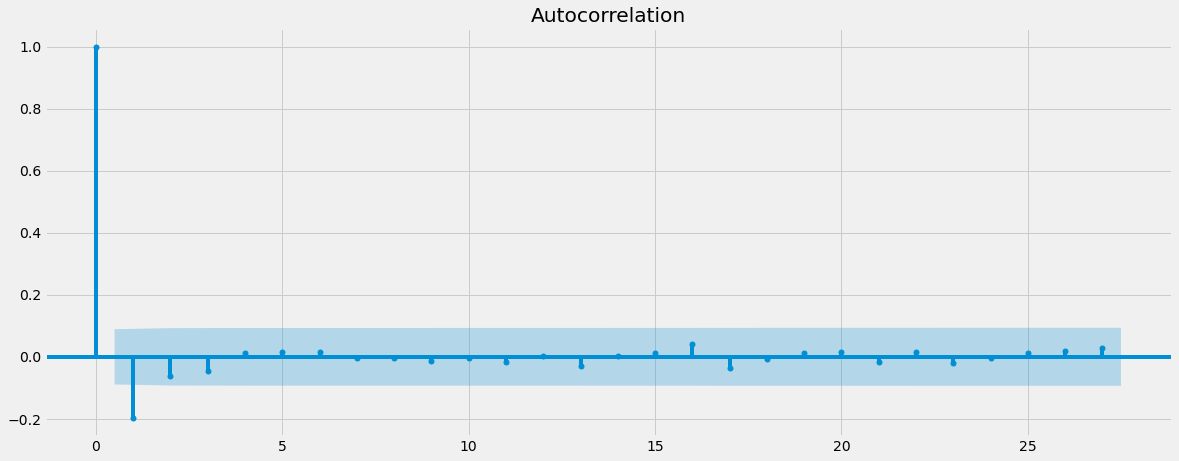

In [56]:
plot_acf(data_diff)
plt.show()